# Strategy analysis example

Debugging a strategy can be time-consuming. Freqtrade offers helper functions to visualize raw data.
The following assumes you work with SampleStrategy, data for 5m timeframe from Binance and have downloaded them into the data directory in the default location.
Please follow the [documentation](https://www.freqtrade.io/en/stable/data-download/) for more details.

## Setup

### Change Working directory to repository root

Cell for imports

In [37]:
import os

Getting project root path

In [38]:
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)
print(project_root)

/home/j/Projects


### Configure Freqtrade environment

In [39]:
from freqtrade.configuration import Configuration

# Change working directory to project root and user SampleStrategy dryrun config
os.chdir(project_root)
config = Configuration.from_files(["configs/config_dryrun_SampleStrategy.json"])
data_location = config["datadir"]
pair = "BTC_USDT"

OperationalException: Config file "configs/config_dryrun_SampleStrategy.json" not found! Please create a config file or check whether it exists.

In [ ]:
# Load data using values set above
from freqtrade.data.history import load_pair_history
from freqtrade.enums import CandleType

data_location = config["datadir"]

candles = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pair,
                            data_format = "feather",  # Make sure to update this to your data
                            candle_type=CandleType.SPOT,
                            )

# Confirm success
print(f"Loaded {len(candles)} rows of data for {pair} from {data_location}")
candles.head()

## Load and run strategy
* Rerun each time the strategy file is changed

In [ ]:
# Load strategy using values set above
from freqtrade.resolvers import StrategyResolver
from freqtrade.data.dataprovider import DataProvider
strategy = StrategyResolver.load_strategy(config)
strategy.dp = DataProvider(config, None, None)
strategy.ft_bot_start()

# Generate buy/sell signals using strategy
df = strategy.analyze_ticker(candles, {'pair': pair})
df.tail()

### Display the trade details

* Note that using `data.head()` would also work, however most indicators have some "startup" data at the top of the dataframe.
* Some possible problems
    * Columns with NaN values at the end of the dataframe
    * Columns used in `crossed*()` functions with completely different units
* Comparison with full backtest
    * having 200 buy signals as output for one pair from `analyze_ticker()` does not necessarily mean that 200 trades will be made during backtesting.
    * Assuming you use only one condition such as, `df['rsi'] < 30` as buy condition, this will generate multiple "buy" signals for each pair in sequence (until rsi returns > 29). The bot will only buy on the first of these signals (and also only if a trade-slot ("max_open_trades") is still available), or on one of the middle signals, as soon as a "slot" becomes available.  


In [ ]:
# Report results
print(f"Generated {df['enter_long'].sum()} entry signals")
data = df.set_index('date', drop=False)
data.tail()

## Load existing objects into a Jupyter notebook

The following cells assume that you have already generated data using the cli.  
They will allow you to drill deeper into your results, and perform analysis which otherwise would make the output very difficult to digest due to information overload.

### Load backtest results to pandas dataframe

Analyze a trades dataframe (also used below for plotting)

In [40]:
from freqtrade.data.btanalysis import load_backtest_data, load_backtest_stats

# if backtest_dir points to a directory, it'll automatically load the last backtest file.
backtest_dir = config["user_data_dir"] / "backtest_results"
# backtest_dir can also point to a specific file 
# backtest_dir = config["user_data_dir"] / "backtest_results/backtest-result-2020-07-01_20-04-22.json"

In [41]:
# You can get the full backtest statistics by using the following command.
# This contains all information used to generate the backtest result.
stats = load_backtest_stats(backtest_dir)

strategy = 'SampleStrategy'
# All statistics are available per strategy, so if `--strategy-list` was used during backtest, this will be reflected here as well.
# Example usages:
print(stats['strategy'][strategy]['results_per_pair'])
# Get pairlist used for this backtest
print(stats['strategy'][strategy]['pairlist'])
# Get market change (average change of all pairs from start to end of the backtest period)
print(stats['strategy'][strategy]['market_change'])
# Maximum drawdown ()
print(stats['strategy'][strategy]['max_drawdown'])
# Maximum drawdown start and end
print(stats['strategy'][strategy]['drawdown_start'])
print(stats['strategy'][strategy]['drawdown_end'])


# Get strategy comparison (only relevant if multiple strategies were compared)
print(stats['strategy_comparison'])


[{'key': 'BTC/USDT', 'trades': 11, 'profit_mean': -0.001066361664050581, 'profit_mean_pct': -0.1066361664050581, 'profit_sum': -0.01172997830455639, 'profit_sum_pct': -1.17, 'profit_total_abs': -1.1567722199999997, 'profit_total': -0.0011567722199999997, 'profit_total_pct': -0.12, 'duration_avg': '1 day, 23:20:00', 'wins': 10, 'draws': 0, 'losses': 1, 'winrate': 0.9090909090909092}, {'key': 'TOTAL', 'trades': 11, 'profit_mean': -0.001066361664050581, 'profit_mean_pct': -0.1066361664050581, 'profit_sum': -0.01172997830455639, 'profit_sum_pct': -1.17, 'profit_total_abs': -1.1567722199999997, 'profit_total': -0.0011567722199999997, 'profit_total_pct': -0.12, 'duration_avg': '1 day, 23:20:00', 'wins': 10, 'draws': 0, 'losses': 1, 'winrate': 0.9090909090909092}]
['BTC/USDT']
-0.024929447821260928
0.10179800073932511
2024-01-11 20:00:00
2024-01-22 18:45:00
[{'key': 'SampleStrategy', 'trades': 11, 'profit_mean': -0.001066361664050581, 'profit_mean_pct': -0.1066361664050581, 'profit_sum': -0.0

In [42]:
# Load backtested trades as dataframe
trades = load_backtest_data(backtest_dir)

# Show value-counts per pair
trades.groupby("pair")["exit_reason"].value_counts()

pair      exit_reason
BTC/USDT  roi            9
          force_exit     1
          stop_loss      1
Name: count, dtype: int64

## Plotting daily profit / equity line

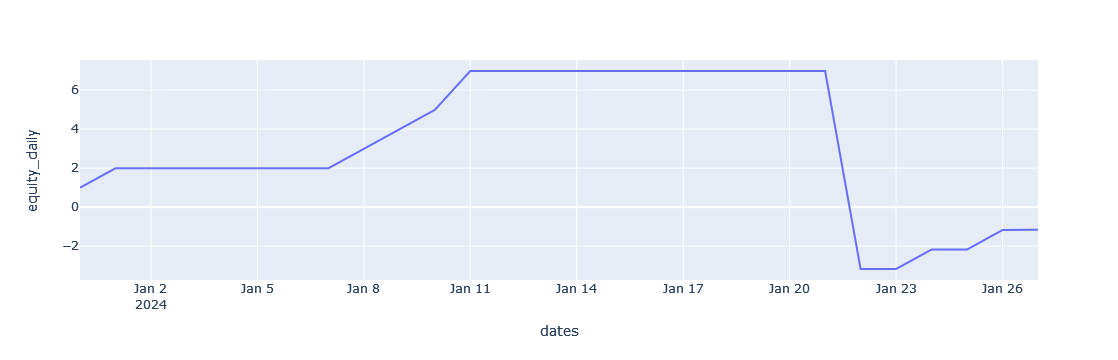

In [43]:
# Plotting equity line (starting with 0 on day 1 and adding daily profit for each backtested day)

from freqtrade.configuration import Configuration
from freqtrade.data.btanalysis import load_backtest_stats
import plotly.express as px
import pandas as pd

# strategy = 'SampleStrategy'
# config = Configuration.from_files(["user_data/config.json"])
# backtest_dir = config["user_data_dir"] / "backtest_results"

stats = load_backtest_stats(backtest_dir)
strategy_stats = stats['strategy'][strategy]

df = pd.DataFrame(columns=['dates','equity'], data=strategy_stats['daily_profit'])
df['equity_daily'] = df['equity'].cumsum()

fig = px.line(df, x="dates", y="equity_daily")
fig.show()


### Load live trading results into a pandas dataframe

In case you did already some trading and want to analyze your performance

In [44]:
from freqtrade.data.btanalysis import load_trades_from_db

# Fetch trades from database
trades = load_trades_from_db("sqlite:///tradesv3.sqlite")

# Display results
trades.groupby("pair")["exit_reason"].value_counts()

Series([], Name: count, dtype: int64)

## Analyze the loaded trades for trade parallelism
This can be useful to find the best `max_open_trades` parameter, when used with backtesting in conjunction with `--disable-max-market-positions`.

`analyze_trade_parallelism()` returns a timeseries dataframe with an "open_trades" column, specifying the number of open trades for each candle.

In [45]:
from freqtrade.data.btanalysis import analyze_trade_parallelism

# Analyze the above
parallel_trades = analyze_trade_parallelism(trades, '5m')

parallel_trades.plot()

ValueError: No objects to concatenate

## Plot results

Freqtrade offers interactive plotting capabilities based on plotly.

In [46]:
from freqtrade.plot.plotting import  generate_candlestick_graph
# Limit graph period to keep plotly quick and reactive

# Filter trades to one pair
trades_red = trades.loc[trades['pair'] == pair]

data_red = data['2019-06-01':'2019-06-10']
# Generate candlestick graph
graph = generate_candlestick_graph(pair=pair,
                                   data=data_red,
                                   trades=trades_red,
                                   indicators1=['sma20', 'ema50', 'ema55'],
                                   indicators2=['rsi', 'macd', 'macdsignal', 'macdhist']
                                  )




In [47]:
# Show graph inline
# graph.show()

# Render graph in a separate window
graph.show(renderer="browser")


Error: could not locate runnable browser

## Plot average profit per trade as distribution graph

In [ ]:
import plotly.figure_factory as ff

hist_data = [trades.profit_ratio]
group_labels = ['profit_ratio']  # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.01)
fig.show()


Feel free to submit an issue or Pull Request enhancing this document if you would like to share ideas on how to best analyze the data.